# MOVEIT


---


The objective of this project is to optimize traffic signal control at a selected intersection within Montevideo’s urban road network using reinforcement learning techniques. Fixed-time traffic light systems lack the ability to respond effectively to temporal variations in traffic demand, resulting in suboptimal performance under real-world conditions.

In this notebook, the SUMO traffic simulator is employed to recreate the intersection and generate realistic traffic dynamics, while TensorFlow is used to develop and train a learning-based traffic signal controller. Through repeated interaction with the simulation environment, the reinforcement learning agent learns policies that adapt signal timings in response to observed traffic states, with the goal of reducing congestion and improving traffic efficiency.

The notebook is designed to be executed in Google Colab, enabling reproducibility and ease of experimentation.

## PATHS & SETUP

### Paths and global variables
This section defines all file paths and global parameters used throughout the notebook. It specifies the SUMO network configuration, input CSV locations for speed and volume data, and the output route/flow file. It also sets key time-related constants, such as the simulation duration (1 hour) and the aggregation window (5 minutes), which are used later to generate traffic flows from the data.

In [135]:
# must point to a "configuration".sumocgf that points to the network
# file and a future flow file must be in the same location as output_xml
network_path = "../SUMO_config/avitalia.sumocfg"
OUTPUT_XML = "../SUMO_config/flows.rou.xml"

# path to the csv
INPUT_CSV_PATH = "../data/raw/"
# name of the csv in the previous path
CSV_SPEED = "11_2025_velocidad.csv"
CSV_VOLUME = "11_2025_volumen.csv"
# the separator used in the above files can be "," or ";"
SEPARATOR = ","
# output of pre-processing csv data
CSV_PATH = "../data/processed/"

# selection of unique timestamps to crate a sequential flow
# in hours
FLOW_START = 0
FLOW_END = 72
# flow generation duration 3600s = 1 hour
FLOW_TIME_BIN = 3600
# data window 5 minutes = 300s
TIME_BIN = 300
# simulation duration
SIM_DURATION = 4600

SEED = 42

### Install and Configure SUMO Dependencies
This section installs SUMO, its command-line tools, and configures the Python environment to enable communication with SUMO via TraCI.

In [2]:
!apt-get update
!apt-get install -y sumo sumo-tools sumo-doc

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 https://repo.mongodb.org/apt/ubuntu focal/mongodb-org/4.4 InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:4 https://repo.mongodb.org/apt/ubuntu noble/mongodb-org/8.2 InRelease
Hit:5 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Reading package lists... Done
W: https://repo.mongodb.org/apt/ubuntu/dists/focal/mongodb-org/4.4/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
sumo is already the newest version (1.18.0+dfsg-3build5).
sumo-tools is already the newest version (1.18.0+dfsg-3build5).
sumo-doc is already the newest version (1.18.0+dfsg-3build5).


SUMO requires the SUMO_HOME environment variable to access its Python tools (including TraCI).

In [136]:
import os
import sys

SUMO_HOME = "/usr/share/sumo"

os.environ["SUMO_HOME"] = SUMO_HOME
sys.path.append(os.path.join(SUMO_HOME, "tools"))
print("SUMO_HOME:", os.environ.get("SUMO_HOME"))
import traci
from traci import constants as tc
print("TraCI imported successfully")

SUMO_HOME: /usr/share/sumo
TraCI imported successfully


Closes opened SUMO simulation befor opening a new simulation, to prevent errors

In [137]:
import uuid

def start_sumo_safe(sumo_cmd):
    label = f"sim_{uuid.uuid4().hex[:8]}"

    try:
        if traci.isLoaded():
            try:
                traci.close(False)
            except Exception:
                pass
    except Exception:
        pass

    traci.start(sumo_cmd, label=label)
    traci.switch(label)

    return label

### Global imports
 This section imports all required libraries for the notebook. It includes tools for interacting with SUMO via TraCI, data manipulation with NumPy and Pandas, XML generation for route/flow files, visualization with Matplotlib and Seaborn, and utility modules for handling JSON data, running external processes, and managing execution timing.

In [138]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

import tensorflow as tf
import numpy as np
import pandas as pd
from xml.etree.ElementTree import Element, SubElement, ElementTree
import matplotlib.pyplot as plt
import seaborn as sns
import json
import subprocess
import time
from tensorflow.keras import layers, models
from collections import deque
import random


## CSV PREPROCESSING


 This function maps combinations of street names from the input data to their corresponding SUMO edge identifiers. It then adapts the lane index `id_carril` to SUMO’s zero-based lane numbering, handling a special case where lane 11 is remapped to 0. The resulting string matches the expected SUMO edge-lane naming format and is used later to align traffic data with the simulation network. Mapping must be done manually as nomenclature is not standardized in between documents.

In [18]:
def map_streets(row):
  key = f"{row['dsc_avenida']},{row['dsc_int_anterior']}"
  mapping = {
      "Av Italia,L A de Herrera": "e_w_01",
      "Av Italia,Cantero W": "e_n",
      "Av Italia,Cantero E": "w_s",
      "Av Italia,Las Heras": "w_e_01",
      "L A de Herrera,Francisco Simon": "n_s_01",
  }
  base_name = mapping.get(key, "Unknown")

  # Transform id_carril: if 11, use 0; otherwise subtract 1
  id_carril = row['id_carril']
  if id_carril == 11:
      suffix = 0
  else:
      suffix = id_carril - 1

  return f"{base_name}_{suffix}"

This function loads a raw traffic CSV file and prepares it for use in the SUMO simulation. It filters records to keep only the intersections of interest, merges date and time fields into a single `datetime` column, and maps street and lane information to SUMO-compatible edge–lane identifiers. Unnecessary columns are removed, relevant fields are renamed to a consistent schema, and traffic volumes are normalized from hourly counts to 5-minute intervals. The result is a clean, standardized DataFrame ready for flow generation and analysis.


In [19]:
def preprocess_csv(load_path: str, save_path: str):
    # Load dataset
    load_path = INPUT_CSV_PATH + load_path
    save_path = INPUT_CSV_PATH + save_path
    df = pd.read_csv(load_path, sep=SEPARATOR)

    # combine street fields into one string per row
    combined = (
        df["dsc_avenida"].fillna("") + " | " +
        df["dsc_int_anterior"].fillna("")
        ).str.lower()

    # Define intersection conditions
    av_italia_herrera = (
        combined.str.contains("av italia", regex=False) &
        combined.str.contains("l a de herrera", regex=False)
    )
    av_italia_las_heras = (
        combined.str.contains("av italia", regex=False) &
        combined.str.contains("las heras", regex=False)
    )
    cantero_w = (
        combined.str.contains("av italia", regex=False) &
        combined.str.contains("cantero w", regex=False)
    )
    cantero_e = (
        combined.str.contains("av italia", regex=False) &
        combined.str.contains("cantero e", regex=False)
    )
    l_a_herrera = (
        combined.str.contains("l a de herrera", regex=False) &
        combined.str.contains("francisco simon", regex=False)
    )

    # Keep rows matching either intersection
    filtered_df = df[av_italia_herrera | av_italia_las_heras | cantero_e | cantero_w | l_a_herrera].copy()

    # Merge fecha and hora (date and time) into datetime column
    filtered_df["datetime"] = pd.to_datetime(filtered_df["fecha"].astype(str) + " " + filtered_df["hora"].astype(str))
    filtered_df["name"] = filtered_df.apply(map_streets, axis=1)

    # Delete unnecessary columns
    filtered_df = filtered_df.drop(columns=["cod_detector", "fecha", "hora", "latitud", "longitud", "dsc_avenida", "dsc_int_anterior", "dsc_int_siguiente", "id_carril"])

    filtered_df = filtered_df.rename(
        {
            "velocidad": "average_speed",
            "volumen_hora": "hourly_volume",
            "volumen": "volume",
        },
        axis=1,
    )

    # NORMALIZE VOLUME TO 5-MIN INTERVALS
    if "volume" not in filtered_df.columns and "hourly_volume" in filtered_df.columns:
      filtered_df["volume"] = pd.NA

      # Convert to numeric safely
      filtered_df["volume"] = pd.to_numeric(filtered_df["volume"], errors="coerce")

      if "hourly_volume" in filtered_df.columns:
          hourly = pd.to_numeric(filtered_df["hourly_volume"], errors="coerce")
          filtered_df.loc[filtered_df["volume"].isna(), "volume"] = hourly / 12

      # Final cleanup
      filtered_df["volume"] = (
          filtered_df["volume"]
          .round()
          .fillna(0)
          .astype("int64")
      )
    return filtered_df

This function merges two preprocessed DataFrames using the shared datetime and name keys. It performs an inner join to keep only matching records and includes a simple consistency check that reports when rows are dropped to evaluate mismatches between the datasets. The merged result is then saved as a single CSV file for generation.

In [25]:
def merge_dfs(df1, df2, path):
    merged_df = pd.merge(df1, df2, on=["datetime", "name"], how="inner")
    if len(merged_df) != len(df1) or len(df1) != len(df2):
        print("No matching rows found between the two datasets.")
        print(f"Length of df1: {len(df1)}")
        print(f"Length of df2: {len(df2)}")
        print(f"Length of merged_df: {len(merged_df)}")
    merged_df.to_csv(path, index=False)

In [26]:
a = preprocess_csv(CSV_SPEED, "speed.csv")
a.to_csv(f"{CSV_PATH}/speed.csv", index=False)
b = preprocess_csv(CSV_VOLUME, "volume.csv")
b.to_csv(f"{CSV_PATH}/volume.csv", index=False)
merge_dfs(a, b, f"{CSV_PATH}/merged.csv")
print(f"Processing complete. Merged data saved to {CSV_PATH}")

Processing complete. Merged data saved to ../data/processed/


##  Plot data


This section prepares the environment for data visualization by creating an output directory, configuring the plotting style, and loading the merged dataset. It ensures the data is time-ordered and derives additional temporal features—such as hour of day, day of month, and weekday—which are later used to analyze and visualize traffic patterns over time. Each Plot generator can be run independently after the first cell is executed.

In [29]:
# Configuration
output_dir = "../data/plots"
os.makedirs(output_dir, exist_ok=True)
sns.set_style("whitegrid")

# Load & preprocess data
df = pd.read_csv(f"{CSV_PATH}/merged.csv", parse_dates=["datetime"])

df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', inplace=True)

# Time features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.dayofweek

weekday_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun'
}

### 1) Total volume over time
This section aggregates vehicle counts across all lanes for each time step and visualizes the resulting total traffic volume as a time series. The line plot highlights temporal trends and fluctuations in overall demand.

In [30]:
volume_time = df.groupby('datetime')['volume'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=volume_time, x='datetime', y='volume')
plt.title('Total Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "total_volume_over_time.png"))
plt.close()

### 2) Average speed over time
This section computes the mean vehicle speed across all lanes for each time step and plots it as a time series. The resulting visualization helps identify periods of congestion or free-flow traffic by showing how average speeds evolve over time.

In [31]:
speed_time = df.groupby('datetime')['average_speed'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=speed_time, x='datetime', y='average_speed', color='orange')
plt.title('Average Speed Over Time')
plt.xlabel('Time')
plt.ylabel('Average Speed (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "average_speed_over_time.png"))
plt.close()

### 3) Heatmap of volume over time per EDGE (lane-aggregated)
This section aggregates lane-level volumes into edge-level totals and reshapes the data into a time–edge matrix. The resulting heatmap visualizes how traffic demand varies across different edges and over time, making it easy to spot recurring congestion patterns and peak periods.

In [32]:
# Extract edge name by removing lane suffix (e.g. e_w_01_0 -> e_w_01)
df['edge'] = df['name'].str.rsplit('_', n=1).str[0]

pivot = df.pivot_table(
    index='datetime',
    columns='edge',
    values='volume',
    aggfunc='sum'
)

plt.figure(figsize=(12,8))
sns.heatmap(
    pivot.T,
    cmap='YlGnBu',
    cbar_kws={'label': 'Volume'}
)

plt.title('Traffic Volume Heatmap (Edge vs Time)')
plt.xlabel('Time')
plt.ylabel('Edge')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "volume_heatmap_edge.png"))
plt.close()

### 4) Demand per hour of day
This section aggregates traffic volumes by hour of the day and visualizes the resulting demand curve. The plot highlights daily demand patterns, such as morning and evening peaks, and provides a clear overview of how traffic intensity varies throughout the day.

In [33]:
hourly_demand = df.groupby('hour')['volume'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_demand, x='hour', y='volume', marker='o')
plt.title('Traffic Demand per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Volume')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "demand_per_hour.png"))
plt.close()

### 5) Demand per day of month
This section aggregates total traffic volume for each day of the month and displays it as a bar chart. The visualization helps identify day-to-day variability, anomalies, or trends in demand across the month.

In [34]:
daily_demand = df.groupby('day')['volume'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=daily_demand, x='day', y='volume', color='steelblue')
plt.title('Traffic Demand per Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Total Volume')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "demand_per_day_of_month.png"))
plt.close()

### 6) Demand per day of week
This section summarizes total traffic volume by weekday and presents it as a bar chart ordered from Monday to Sunday. The visualization reveals systematic differences between weekdays and weekends, helping to distinguish regular commuting patterns from off-peak or leisure traffic.

In [35]:
weekday_demand = df.groupby('weekday')['volume'].sum().reset_index()
weekday_demand['weekday'] = weekday_demand['weekday'].map(weekday_map)

plt.figure(figsize=(10,6))
sns.barplot(
    data=weekday_demand,
    x='weekday',
    y='volume',
    order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    color='darkorange'
)
plt.title('Traffic Demand per Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Volume')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "demand_per_day_of_week.png"))
plt.close()

print(f"All plots saved in folder '{output_dir}'")

All plots saved in folder '../data/plots'


## Route and demand configuration
Sets up the demand according to real life data in a time period of 5 minutes, set probability for turning inferred from volume data on dataset

### FILE CONFIG

In [36]:
VEH_TYPE_ID = "car"
routes = Element("routes")

# Define the vehicle dynamics and driver behavior parameters used by all simulated vehicles.
SubElement(
    routes,
    "vType",
    id=VEH_TYPE_ID,
    accel="2.6",
    decel="4.5",
    length="5",
    sigma="0.5",
    maxSpeed="13.9"
)

<Element 'vType' at 0x7a7e85442f70>

### CALCULATE TURNING PROBABILITIES
Turning movement data were available for a single representative incoming lane. The observed turning proportions from this lane were used to estimate turning probabilities, which were then applied uniformly to all incoming lanes in the network. This assumption was made to compensate for the lack of complete turning movement data and to ensure consistent route assignment across the intersection.

In [37]:
df = pd.read_csv(f"{CSV_PATH}/merged.csv", parse_dates=["datetime"])

# Lanes BEFORE the split (total upstream demand)
TOTAL_LANES = [
    "e_w_01_0",
    "e_w_01_1",
    "e_w_01_2",
    "w_e_01_0",
    "w_e_01_1",
    "w_e_01_2",
]

# Lane AFTER the split that represents right turns
RIGHT_TURN_LANE = ["e_n_0", "e_n_1", "w_s_0"]

# Total vehicles before the split
v_total = df.loc[df["name"].isin(TOTAL_LANES), "hourly_volume"].sum()
print("Total upstream volume:", v_total)

# Vehicles that turned right
v_right = df.loc[df["name"].isin(RIGHT_TURN_LANE), "hourly_volume"].sum()
if v_total == 0:
    raise ValueError("Total upstream volume is zero — cannot compute probabilities")

# Compute turning probabilities
p_turn = v_right / v_total
p_non_right = 1.0 - p_turn * 2

# TURN_PROB dictionary
TURN_PROB = {
    "right": p_turn,
    "straight": 0.9 * p_non_right,
    "left":     p_turn,
    "uturn":    0.1 * p_non_right
}

assert abs(sum(TURN_PROB.values()) - 1.0) < 1e-6

print("Turning probabilities:")
for k, v in TURN_PROB.items():
    print(f"  {k}: {v:.3f}")

Total upstream volume: 1661960
Turning probabilities:
  right: 0.060
  straight: 0.792
  left: 0.060
  uturn: 0.088


### Route and lane configuration for flow generation

This section defines the mapping between incoming edges and their possible movements (straight, left, right, and U-turn), along with the corresponding SUMO route IDs and lane assignments. It then specifies the full edge sequences for each route and programmatically adds them to the routes XML file. These definitions form the structural basis for generating realistic traffic flows aligned with the network geometry.

In [38]:
ROUTES_BY_ORIGIN = {
    "e_w_01": {
        "straight": "r_e_w_01_straight",
        "left":     "r_e_w_01_left",
        "right":    "r_e_w_01_right",
        "uturn":    "r_e_w_01_uturn",
    },
    "n_s_01": {
        "straight": "r_n_s_01_straight",
        "left":     "r_n_s_01_left",
        "right":    "r_n_s_01_right",
        "uturn":    "r_n_s_01_uturn",
    },
    "s_n_01": {
        "straight": "r_s_n_01_straight",
        "left":     "r_s_n_01_left",
        "right":    "r_s_n_01_right",
        "uturn":    "r_s_n_01_uturn",
    },
    "w_e_01": {
        "straight": "r_w_e_01_straight",
        "left":     "r_w_e_01_left",
        "right":    "r_w_e_01_right",
        "uturn":    "r_w_e_01_uturn",
    }
}
LANES_BY_ORIGIN = {
    "e_w_01": ["e_w_01_0", "e_w_01_1", "e_w_01_2"],
    "n_s_01": ["n_s_01_0", "n_s_01_1"],
    "s_n_01": ["s_n_01_0", "s_n_01_1"],
    "w_e_01": ["w_e_01_0", "w_e_01_1"],
}
ROUTE_DEFS = {
    "r_e_w_01_straight": "e_w_01 e_w_02 e_w_03 e_w_04 e_w_05",
    "r_e_w_01_left":     "e_w_01 e_w_02 n_s_03 n_s_04",
    "r_e_w_01_right":    "e_w_01 e_n s_n_04",
    "r_e_w_01_uturn":    "e_w_01 e_w_02 w_e_03 w_e_04 w_e_05",

    "r_n_s_01_straight": "n_s_01 n_s_02 n_s_03 n_s_04",
    "r_n_s_01_left":     "n_s_01 n_w e_w_04 e_e w_e_02 w_e_03 w_e_04 w_e_05",
    "r_n_s_01_right":    "n_s_01 n_w e_w_04 e_w_05",
    "r_n_s_01_uturn":    "n_s_01 n_w e_w_04 e_e w_e_02 s_n_03 s_n_04",

    "r_s_n_01_straight": "s_n_01 s_n_02 s_n_03 s_n_04",
    "r_s_n_01_left":     "s_n_01 s_e w_e_04 w_w e_w_02 e_w_03 e_w_04 e_w_05",
    "r_s_n_01_right":    "s_n_01 s_e w_e_04 w_e_05",
    "r_s_n_01_uturn":    "s_n_01 s_e w_e_04 w_w e_w_02 n_s_03 n_s_04",

    "r_w_e_01_straight": "w_e_01 w_e_02 w_e_03 w_e_04 w_e_05",
    "r_w_e_01_left":     "w_e_01 w_e_02 s_n_03 s_n_04",
    "r_w_e_01_right":    "w_e_01 w_s n_s_04",
    "r_w_e_01_uturn":    "w_e_01 w_e_02 e_w_03 e_w_04 e_w_05",
}

for rid, edges in ROUTE_DEFS.items():
    SubElement(routes, "route", id=rid, edges=edges)

### Time-step data selection and lane duplication

This function extracts all traffic measurements for a given simulation timestamp, excluding sensors that are not used in the model. To compensate for missing detectors, it duplicates selected north–south lane measurements and remaps them to their corresponding south–north lanes. The resulting DataFrame represents a complete, time-consistent snapshot of lane-level demand used for flow generation at that time step.

In [39]:
def selection(ts):
    # Base selection (drop unwanted sensors)
    group = df[
        (df["datetime"] == ts) &
        (~df["name"].isin(["e_n_0", "w_s_0", "e_n_1"]))
    ]

    # Duplicate n_s_01_0 → s_n_01_0
    dup_0 = group[group["name"] == "n_s_01_0"].copy()
    dup_0.loc[:, "name"] = "s_n_01_0"

    # Duplicate n_s_01_1 → s_n_01_1
    dup_1 = group[group["name"] == "n_s_01_1"].copy()
    dup_1.loc[:, "name"] = "s_n_01_1"

    # Append both duplicates
    group = pd.concat([group, dup_0, dup_1], ignore_index=True)

    print(group)
    return group

### Flow reset utility

This helper function removes all existing `flow` elements from the routes XML structure. It is used to clear previously generated traffic flows before creating new ones, ensuring that each simulation run starts with a clean and consistent set of flow definitions.

In [45]:
def clear_flows(routes):
  global flow_id
  flow_id = 0
  for flow in list(routes.findall("flow")):
    routes.remove(flow)

### Sequential flow generation per time window

This section defines the logic for converting time-stamped traffic data into SUMO flow definitions. It maps each timestamp to simulation seconds, selects the corresponding lane-level measurements, and aggregates demand by origin edge. For each origin, total volume is split into turning movements using predefined probabilities and converted to vehicles per hour over a fixed time window. Each movement is then added as a unique `flow` element to the routes file, enabling time-varying demand that follows the observed data.

In [42]:
def sequential_ts(ts_list):
  global SIM_START_TS
  SIM_START_TS = ts_list[0]
  for ts in ts_list:
        sequential_flow(ts)

def ts_to_sim_seconds(ts):
    return int((ts - SIM_START_TS).total_seconds())

def sequential_flow(ts):
    global flow_id
    group = selection(ts)

    begin = ts_to_sim_seconds(ts)
    end = begin + FLOW_TIME_BIN

    window_hours = FLOW_TIME_BIN / 3600.0

    for origin_edge, lanes in LANES_BY_ORIGIN.items():

        volume_total = group.loc[
            group["name"].isin(lanes),
            "hourly_volume"
        ].sum()

        if volume_total <= 0:
            continue

        for movement, prob in TURN_PROB.items():

            route_id = ROUTES_BY_ORIGIN[origin_edge][movement]
            movement_volume = volume_total * prob
            vehs_per_hour = movement_volume / window_hours

            SubElement(
                routes,
                "flow",
                id=f"flow_{flow_id}",
                begin=str(begin),
                end=str(end),
                vehsPerHour=f"{vehs_per_hour:.2f}",
                type=VEH_TYPE_ID,
                departLane="best",
                departSpeed="max",
                route=route_id
            )

            flow_id += 1

This section orchestrates the creation of traffic flows over multiple simulation time steps. It first clears any existing flows from the routes file, then iterates over a selected range of timestamps and generates sequential flow definitions for each one. The result is a temporally ordered set of flows that reproduces time-varying traffic demand within the SUMO simulation.

In [46]:
clear_flows(routes)
ts = df["datetime"].sort_values().unique()[(FLOW_START * 12):(FLOW_END * 12)]
sequential_ts(ts)

   average_speed   datetime      name  hourly_volume  volume
0           34.0 2025-11-01  e_w_01_0             16       1
1           35.0 2025-11-01  e_w_01_1             26       2
2            8.0 2025-11-01  e_w_01_2              3       0
3            9.0 2025-11-01  w_e_01_0             19       2
4           30.0 2025-11-01  w_e_01_1             27       2
5           43.0 2025-11-01  w_e_01_2             12       1
6           24.0 2025-11-01  n_s_01_0             25       2
7           13.0 2025-11-01  n_s_01_1            105       9
8           24.0 2025-11-01  s_n_01_0             25       2
9           13.0 2025-11-01  s_n_01_1            105       9
   average_speed            datetime      name  hourly_volume  volume
0           36.0 2025-11-01 00:05:00  e_w_01_0             27       2
1           36.0 2025-11-01 00:05:00  e_w_01_1             26       2
2           10.0 2025-11-01 00:05:00  e_w_01_2              7       1
3           23.0 2025-11-01 00:05:00  w_e_01_0   

### Single–time-slice flow generation

This function generates a complete set of SUMO flows for a single time snapshot. It selects lane-level demand for the given timestamp, clears any existing flows, and aggregates volumes by origin edge. The total demand is then split into turning movements using predefined probabilities and converted into vehicles per hour for a fixed simulation window. The resulting flows represent a static traffic scenario corresponding to one specific moment in time.

In [ ]:
def create_flow(ts):
    group = selection(ts)
    clear_flows(routes)
    begin = 0
    end = FLOW_TIME_BIN

    for origin_edge, lanes in LANES_BY_ORIGIN.items():

        volume_total = group.loc[
            group["name"].isin(lanes),
            "volume"
        ].sum()

        if volume_total == 0:
            continue

        for movement, prob in TURN_PROB.items():

            route_id = ROUTES_BY_ORIGIN[origin_edge][movement]
            movement_volume = volume_total * prob
            vehs_per_hour = movement_volume * 3600

            SubElement(
                routes,
                "flow",
                id=f"flow_{FLOW_ID_COUNTER}",
                begin=str(begin),
                end=str(end),
                vehsPerHour=f"{vehs_per_hour:.2f}",
                type=VEH_TYPE_ID,
                departLane="best",
                departSpeed="max",
                route=route_id
            )

            FLOW_ID_COUNTER += 1


This commented snippet shows how to generate traffic flows for a single selected timestamp from the dataset. By uncommenting and choosing a specific index, it allows quick testing or inspection of the flows produced for an individual time slice without running the full time-series generation.

In [ ]:
#ts = df["datetime"].sort_values().unique()[1315]
#create_flow(ts)

### Export of routes and flows XML

This final section writes the complete routes and flow definitions to an XML file in SUMO format. It confirms successful generation by reporting the output file location, the number of flows created, and the total number of route definitions included, providing a quick sanity check before running the simulation.

In [47]:
ElementTree(routes).write(
    OUTPUT_XML,
    encoding="utf-8",
    xml_declaration=True
)
print(f"Generated {OUTPUT_XML}")
print(f"Flows created: {flow_id}")
print("Routes:", len(routes.findall("route")))

Generated ../SUMO_config/flows.rou.xml
Flows created: 13820
Routes: 16


Validate the flow generation starts at 0 and ends at the correct time

In [50]:
flows = routes.findall("flow")
print("First begin:", flows[0].get("begin"))
print("Last end:", flows[-1].get("end"))

First begin: 0
Last end: 262500


## Static Base-line simulation

### Simulation control configuration

This section defines the set of lanes monitored and controlled by the traffic light logic, separating those at the intersection from upstream “long” lanes used for state observation. It also specifies the SUMO command-line configuration, including the network file, random seed, and logging options, which is later used to launch the simulation in a reproducible and controlled manner.

In [51]:
CONTROLLED_LANES = [
    "w_e_02_0", "w_e_02_1", "w_e_02_2", "w_e_02_3", "w_e_02_4",
    "e_w_02_0", "e_w_02_1", "e_w_02_2", "e_w_02_3", "e_w_02_4",
    "n_s_02_0", "n_s_02_1",
    "s_n_02_0", "s_n_02_1"
]

LONG_LANES = [
    "w_e_01_0", "w_e_01_1", "w_e_01_2",
    "n_s_01_0", "n_s_01_1",
    "s_n_01_0", "s_n_01_1",
    "e_w_01_0", "e_w_01_1", "e_w_01_2"
]

SUMO_CMD = [
    "sumo",
    "-c", network_path,
    "--seed", str(SEED),
    "--start",
    "--quit-on-end",
    "--no-step-log",
    "--time-to-teleport", "-1",
    "--duration-log.statistics"
]

### METRIC FUNCTIONS
These helper functions compute a soft estimate of queue length based on vehicle speeds. A vehicle is considered queued if its speed falls below a given threshold, and the queue length of a lane is the count of such vehicles in the last simulation step. The total queue metric aggregates this estimate across all controlled lanes and is later used to evaluate intersection performance.

In [52]:
def soft_queue(lane, speed_thr=1.0):
    return sum(
        traci.vehicle.getSpeed(v) < speed_thr
        for v in traci.lane.getLastStepVehicleIDs(lane)
    )

def total_queue():
    return sum(soft_queue(l) for l in CONTROLLED_LANES)

### Simulation loop and performance metric collection

This section runs the SUMO simulation step by step and collects key performance metrics after an initial warm-up period. It tracks vehicle departures and arrivals to compute individual trip times, estimates queue lengths at each step using the soft queue metric, and accumulates incremental waiting time across all vehicles. After the simulation ends, the collected series are converted to NumPy arrays for efficient analysis and visualization.

In [55]:
prev_wait = {}
queue_series = []
wait_series = []
depart_times = {}
trip_times = []
prev_veh_ids = set()

start_sumo_safe(SUMO_CMD)

for step in range(SIM_DURATION):
    traci.simulationStep()

    veh_ids = set(traci.vehicle.getIDList())
    # Detect newly departed vehicles
    new_veh = veh_ids - prev_veh_ids
    for v in new_veh:
        depart_times[v] = step

    # Detect arrived vehicles
    arrived_veh = prev_veh_ids - veh_ids
    for v in arrived_veh:
        if v in depart_times:
            trip_times.append(step - depart_times[v])
            del depart_times[v]

    prev_veh_ids = veh_ids
    # queue
    q = total_queue()
    queue_series.append(q)

    # waiting time
    step_wait = 0.0
    for veh in traci.vehicle.getIDList():
        cur = traci.vehicle.getAccumulatedWaitingTime(veh)
        prev = prev_wait.get(veh, cur)
        step_wait += cur - prev
        prev_wait[veh] = cur

    wait_series.append(step_wait)

traci.close()

queue_arr = np.array(queue_series)
wait_arr = np.array(wait_series)
trip_arr = np.array(trip_times)

 Retrying in 1 seconds
***Starting server on port 47639 ***
Loading net-file from '../SUMO_config/./intersection.net.xml' ... done (26ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Simulation ended at time: 4600.00
Reason: TraCI requested termination.
Performance: 
 Duration: 58.31s
 TraCI-Duration: 55.72s
 Real time factor: 78.8928
 UPS: 5537.877099
Vehicles: 
 Inserted: 3076 (Loaded: 3191)
 Running: 139
 Waiting: 115
Statistics (avg of 2937):
 RouteLength: 480.86
 Speed: 6.17
 Duration: 105.58
 WaitingTime: 50.93
 TimeLoss: 67.23
 DepartDelay: 13.14



### Performance metrics aggregation and export

This section summarizes the simulation results into a set of key performance indicators, including travel time statistics, queue characteristics, congestion ratio, and average waiting time. The metrics are organized into a structured dictionary, printed for quick inspection, and saved to a JSON file for reproducibility, comparison across controllers, or downstream analysis.


In [56]:

metrics = {
    "controller": "static_fixed_time",
    "seed": SEED,
    "num_completed_trips": int(len(trip_arr)),
    "median_travel_time": float(np.median(trip_arr)),
    "mean_travel_time": float(trip_arr.mean()),
    "p95_travel_time": float(np.percentile(trip_arr, 95)),
    "max_travel_time": float(trip_arr.max()),
    "avg_queue": float(queue_arr.mean()),
    "p95_queue": float(np.percentile(queue_arr, 95)),
    "max_queue": int(queue_arr.max()),
    "congested_ratio": float((queue_arr > 5).mean()),
    "avg_waiting_time_per_second": float(wait_arr.mean())
}

print(json.dumps(metrics, indent=2))
with open("../results/jsons/travel_time_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

{
  "controller": "static_fixed_time",
  "seed": 42,
  "num_completed_trips": 2937,
  "median_travel_time": 91.0,
  "mean_travel_time": 105.57950289410964,
  "p95_travel_time": 266.0,
  "max_travel_time": 401.0,
  "avg_queue": 12.328695652173913,
  "p95_queue": 20.0,
  "max_queue": 25,
  "congested_ratio": 0.8758695652173913,
  "avg_waiting_time_per_second": 24.441304347826087
}


## Simulation for RL

### SETUP

Initializes the SUMO simulation via TraCI, retrieves the traffic light phases for intersection J5 to define the action space, and identifies the controlled and long incoming lanes used in the state definition.

In [109]:
# ---- Flow windowing ----
FLOW_HOURS = 72
EPISODE_HOURS = 2
FLOW_SECONDS = FLOW_HOURS * 3600
EPISODE_SECONDS = EPISODE_HOURS * 3600
TEST_START = 8 * 3600
TEST_END = 10 * 3600

def build_sumo_cmd(begin_time, end_time):
    return [
        "sumo",
        "-c", network_path,
        "--begin", str(begin_time),
        "--end", str(end_time),
        "--time-to-teleport", "-1",
        "--no-step-log", "--no-warnings",
        "--log", "/dev/null",
        "--error-log", "/dev/null",
        "--start"
    ]

In [ ]:
CONTROLLED_TLS = "J5"
phase_start_time = {}
N_ACTIONS = 4
JUNCTION_ID = "intersection"
MAX_SPEED = 16 # meters per second
MAX_WAIT = 2000 # seconds
MAX_VEHICLES_PER_CELL = 20
RADIUS = 200.0
GRID_SIZE = 10
CELL_SIZE = (2 * RADIUS) / GRID_SIZE
ACTION_TO_PHASE = {
    0: 0,  # NS straight
    1: 2,  # EW straight
    2: 4,  # WE left
    3: 6,  # EW left
}
MIN_GREEN = 5
early_switch_penalty = 0.05
YELLOW_TIME = 4
GREEN_PHASES = [0, 2, 4, 6]
N_EPISODES = 4000
EPSILON = 1.0  # Initial epsilon for exploration
gamma = 0.95  # Discount factor
EPS_MIN = 0.05
EPS_DECAY = 0.999
EPISODE_LOG = []
EVAL_LOG = []
STEP_LOG = []
SPILLBACK_THR = 0.8

# REWARD
ALPHA = 0.8
BETA = 0.5
GAMMA = 0.6

EVAL_INTERVAL = 100
BEST_EVAL_REWARD = -np.inf
PATIENCE = 6

# Checkpoint
CHECKPOINT_DIR = "../results/logs/sarsa_dqn_checkpoint_02"

### ENVIROMENT

In [111]:
class TLSState:
    def __init__(self):
        self.phase = {}
        self.time = 0.0

    def update_tls_state(self, tls_id):
      self.phase[tls_id] = traci.trafficlight.getPhase(tls_id)
      self.time = traci.simulation.getTime()

def process_pending_switches():
    for tls_id, sw in list(pending_switch.items()):
        if tls_state.time >= sw["until"]:
            traci.trafficlight.setPhase(tls_id, sw["target"])
            traci.trafficlight.setPhaseDuration(tls_id, 10_000)
            phase_start_time[tls_id] = tls_state.time
            del pending_switch[tls_id]

tls_state = TLSState()
pending_switch = {}


In [ ]:
def subscribe_existing_vehicles():
    for vid in traci.vehicle.getIDList():
        traci.vehicle.subscribe(vid, [
            tc.VAR_POSITION,
            tc.VAR_SPEED,
            tc.VAR_WAITING_TIME,
            tc.VAR_LANE_ID,
        ])

In [113]:
class SumoEnv:
  def __init__(self, tls_id, max_decisions=120):
    self.tls_id = tls_id
    self.max_decisions = max_decisions
    self.t = 0
    self.prev_q = 0.0
    self.cx, self.cy = 0.0, 0.0
    self.flow_start = 0
    self.flow_end = 0
    self.LANES = [
        "w_e_02_0", "w_e_02_1", "w_e_02_2", "w_e_02_3", "w_e_02_4",
        "e_w_02_0", "e_w_02_1", "e_w_02_2", "e_w_02_3", "e_w_02_4",
        "n_s_02_0", "n_s_02_1", "e_w_01_0", "e_w_01_1", "e_w_01_2",
        "s_n_02_0", "s_n_02_1", "w_e_01_0", "w_e_01_1", "w_e_01_2",
        "n_s_01_0", "n_s_01_1", "s_n_01_0", "s_n_01_1"
    ]

  def reset(self, eval=False):
    global phase_start_time

    phase_start_time.clear()
    pending_switch.clear()
    if eval:
        self.flow_start = TEST_START
        self.flow_end = TEST_END
    else:
        # Randomize flow window
        self.flow_start = np.random.randint(
            0,
            FLOW_SECONDS - EPISODE_SECONDS
        )
        self.flow_end = self.flow_start + EPISODE_SECONDS

    SUMO_CMD = build_sumo_cmd(self.flow_start, self.flow_end)
    start_sumo_safe(SUMO_CMD)

    self.t = 0
    self.prev_q = 0.0
    traci.simulationStep()
    subscribe_existing_vehicles()
    tls_state.update_tls_state(self.tls_id)
    phase_start_time[self.tls_id] = tls_state.time
    # get junction center
    self.cx, self.cy = traci.junction.getPosition(JUNCTION_ID)
    vehicle_cache = update_vehicle_cache()
    self.prev_q = get_queue_arr_from_cache(vehicle_cache, self.LANES).mean()
    occ, speed, wait = get_intersection_state(vehicle_cache, self.cx, self.cy)
    grid = np.stack([occ, speed, wait], axis=-1)
    return grid


  def step(self, action):
    occ, speed, wait, reward, q_prev = step_controller(self, action, self.LANES, self.prev_q)
    state = np.stack([occ, speed, wait], axis=-1)
    self.prev_q = q_prev
    self.t += 1
    done = self.t >= self.max_decisions or traci.simulation.getMinExpectedNumber() == 0
    return state, reward, done

  def legal_actions(self):
    return legal_actions(self.tls_id)

### GET Grid State

In [114]:
def get_intersection_state(vehicle_cache, cx, cy):
    # define the matrix
    occupancy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)
    speed = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)
    wait = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)

    for v in vehicle_cache.values():
        x, y = v["pos"]
        dx, dy = x - cx, y - cy

        # Check observation radius
        if abs(dx) > RADIUS or abs(dy) > RADIUS:
            continue

        # Map to grid
        col = int((dx + RADIUS) / CELL_SIZE)
        row = int((dy + RADIUS) / CELL_SIZE)

        if 0 <= row < GRID_SIZE and 0 <= col < GRID_SIZE:
            occupancy[row, col] += 1 # count vehicles
            speed[row, col] += v["speed"]
            wait[row, col] += v["wait"]

    # average speed on occupied cell
    mask = occupancy > 0
    speed[mask] /= occupancy[mask]
    wait[mask] /= occupancy[mask]

    speed /= MAX_SPEED
    wait /= MAX_WAIT
    occupancy /= MAX_VEHICLES_PER_CELL

    return occupancy, speed, wait

In [115]:
def update_vehicle_cache():
    global total_wait
    total_wait = 0.0
    vehicles = {}

    sub = traci.vehicle.getAllSubscriptionResults()
    for vid, d in sub.items():
        wait = d[tc.VAR_WAITING_TIME]
        vehicles[vid] = {
            "pos": d[tc.VAR_POSITION],
            "speed": d[tc.VAR_SPEED],
            "wait": wait,
            "lane": d[tc.VAR_LANE_ID],
        }
        total_wait += wait

    return vehicles


### ACTION SPACE


Defines the state representation by combining local intersection congestion metrics with upstream traffic volumes from longer lanes, and provides a function to apply traffic light phase actions.

In [117]:
def legal_actions(tls_id):
    current_phase = tls_state.phase[tls_id]

    # Yellow → only allow staying in previous green phase
    if current_phase not in GREEN_PHASES:
        # find green phase that was active before yellow
        previous_green = current_phase - 1  # yellow follows green in SUMO convention
        legal = [a for a, p in ACTION_TO_PHASE.items() if p == previous_green]
        if not legal:
            # fallback: allow first action
            legal = [0]
        return legal

    # Otherwise → all green phases allowed
    return list(ACTION_TO_PHASE.keys())

In [116]:
def apply_action(tls_id, action):
  if tls_id in pending_switch:
    return False

  # Guard legality
  current_phase = tls_state.phase[tls_id]
  if action not in legal_actions(tls_id):
      return False

  # Only switch if different
  target_phase = ACTION_TO_PHASE[action]
  if current_phase == target_phase:
      return True

  # Go yellow
  yellow_phase = current_phase + 1 if current_phase % 2 == 0 else current_phase

  traci.trafficlight.setPhase(tls_id, yellow_phase)
  traci.trafficlight.setPhaseDuration(tls_id, YELLOW_TIME)

  # Register pending switch
  pending_switch[tls_id] = {
      "target": target_phase,
      "until": tls_state.time + YELLOW_TIME
  }
  return True

In [118]:
def select_action(qnet, state, legal, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(legal)
    q = qnet(state[None, ...], training=False)[0].numpy()
    return int(legal[np.argmax(q[legal])])

In [119]:
def advance_until_decision(tls_id):
    while True:
        try:
            traci.simulationStep()
        except traci.exceptions.FatalTraCIError:
            return  # SUMO exited

        process_pending_switches()
        tls_state.update_tls_state(tls_id)

        if tls_state.phase[tls_id] in GREEN_PHASES:
            break


### Computes the reward

In [120]:
def get_queue_arr_from_cache(vehicle_cache, lanes, speed_thr=3.0):
    lane_q = {l: 0.0 for l in lanes}
    for v in vehicle_cache.values():
        if v["lane"] in lane_q:
            lane_q[v["lane"]] += max(0.0, 1.0 - v["speed"] / speed_thr)
    return np.array([lane_q[l] for l in lanes], dtype=np.float32)

In [121]:
def get_reward(queue_arr, dq):
    mean_q = queue_arr.mean()
    spillback = np.sum(queue_arr > SPILLBACK_THR)

    reward = (
        -ALPHA * mean_q           # absolute congestion
        -BETA * spillback        # spillback prevention
        -GAMMA * dq               # smooth pressure shaping
    )

    return reward, mean_q

### DEEP SARSA

In [122]:
def build_sarsa_qnet(grid_shape, n_actions):
    grid_input = layers.Input(shape=grid_shape, name="grid")

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(grid_input)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    q_values = layers.Dense(n_actions, activation=None)(x)

    model = models.Model(
        inputs=grid_input,
        outputs=q_values
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2.5e-4),
        loss="mse"
    )

    return model

### Logging  

In [ ]:
def reset_step_log():
    global STEP_ACC
    STEP_ACC = {
            "count": 0,
            "mean_queue": 0.0,
            "mean_wait": 0.0,
            "spillback": 0.0,
        }

def log_step(reward, vehicle_cache, queue_arr):
    STEP_ACC["count"] += 1
    STEP_ACC["mean_queue"] += float(queue_arr.mean())
    STEP_ACC["spillback"] += int((queue_arr > 1).sum())

    if vehicle_cache:
        STEP_ACC["mean_wait"] += total_wait / len(vehicle_cache)

def summarize_episode():
    c = STEP_ACC["count"]
    if c == 0:
        return {
            "mean_queue": 0.0,
            "mean_wait": 0.0,
            "spillback": 0.0,
        }

    return {
        "mean_queue": STEP_ACC["mean_queue"] / c,
        "mean_wait": STEP_ACC["mean_wait"] / c,
        "spillback": int(STEP_ACC["spillback"] / c),
    }

### STEP EXECUTION

In [123]:
def step_controller(env, action, lanes, prev_mean_queue):
    
    # assert early phase switching
    vehicle_cache = update_vehicle_cache()
    current_phase = tls_state.phase[CONTROLLED_TLS]
    current_green = current_phase if current_phase in GREEN_PHASES else current_phase - 1
    elapsed = tls_state.time - phase_start_time[CONTROLLED_TLS]

    early_switch = (
        elapsed < MIN_GREEN and
        ACTION_TO_PHASE[action] != current_green
    )

    # Apply action using cached state
    valid = apply_action(CONTROLLED_TLS, action)

    # Advance until next decision point
    advance_until_decision(CONTROLLED_TLS)

    # Get intersection vehicles
    vehicle_cache = update_vehicle_cache()

    # Reward
    queue_after = get_queue_arr_from_cache(vehicle_cache, lanes)
    dq = queue_after.mean() - prev_mean_queue
    reward, prev_mean_queue = get_reward(queue_after, dq)

    # Not MIN_GREEN
    if early_switch or not valid:
      reward -= early_switch_penalty * (1 + prev_mean_queue)

    # Next state
    occ, speed, wait = get_intersection_state(vehicle_cache, env.cx, env.cy)

    # Logging
    log_step(reward, vehicle_cache, queue_after)

    return occ, speed, wait, reward, prev_mean_queue

### EPISODE EXECUTION

In [124]:
def run_episode(env, qnet, epsilon, gamma=0.99):
    reset_step_log()
    state = env.reset()
    done = False
    total_reward = 0.0
    steps = 0

    legal = env.legal_actions()
    action = select_action(qnet, state, legal, epsilon)

    while not done:
        next_state, reward, done = env.step(action)
        legal_next = env.legal_actions()
        # Decision point → SARSA selects next action
        next_action = select_action(qnet, next_state, legal_next, epsilon)
        q_next = tf.stop_gradient(
            qnet(next_state[None, ...], training=False)[0, next_action]
        )

        # SARSA target
        target = reward + gamma * q_next

        # Q-network update
        with tf.GradientTape() as tape:
            q_values = qnet(state[None, ...], training=True)[0]
            mask = tf.one_hot(action, N_ACTIONS)
            q_sa = tf.reduce_sum(q_values * mask)
            loss = tf.square(target - q_sa)

        grads = tape.gradient(loss, qnet.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 5.0)
        qnet.optimizer.apply_gradients(zip(grads, qnet.trainable_variables))

        total_reward += reward
        steps += 1
        state, action = next_state, next_action

    return total_reward, steps

In [125]:
def run_eval_episode(env, qnet):
    reset_step_log()
    state = env.reset(eval=True)
    done = False
    total_reward = 0.0
    action = None

    while not done:
        legal = env.legal_actions()

        # Decision point → greedy action
        action = select_action(qnet, state, legal, epsilon=0.0)

        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state

    metrics = summarize_episode()

    return {
        "reward": total_reward,
        **metrics
    }

### checkpoint saver and training loop

In [ ]:
# Instantiate the environment
env = SumoEnv(tls_id=CONTROLLED_TLS)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Define grid_shape and phase_dim for the Q-network
grid_shape = (GRID_SIZE, GRID_SIZE, 3) # occupancy, speed, wait

# Build the Q-network
qnet = build_sarsa_qnet(grid_shape, N_ACTIONS)

print("Environment and Q-network initialized successfully!")
step = 0
episodes_elapsed = 0
patience = 0
epsilon = EPSILON

ckpt = tf.train.Checkpoint(
    step=tf.Variable(0),
    episode=tf.Variable(0),
    optimizer=qnet.optimizer,
    model=qnet,
    epsilon=tf.Variable(epsilon)
)

ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    directory=CHECKPOINT_DIR,
    max_to_keep=5
)
ckpt.step.assign(step)
ckpt.epsilon.assign(epsilon)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    step = int(ckpt.step.numpy())
    episodes_elapsed = int(ckpt.episode.numpy())
    epsilon = float(ckpt.epsilon.numpy())
    print(f"Restored from checkpoint at step {step}, episode {episodes_elapsed} / {N_EPISODES}, epsilon={epsilon:.4f}")
else:
    print("Starting training from scratch")
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    open(f"{CHECKPOINT_DIR}/config.json", 'w').close()

episode_rewards = []
CONFIG = {
    "FLOW_HOURS": FLOW_HOURS,
    "EPISODE_HOURS": EPISODE_HOURS,
    "GRID_SIZE": GRID_SIZE,
    "RADIUS": RADIUS,
    "MIN_GREEN": MIN_GREEN,
    "GAMMA": gamma,
    "EPS_DECAY": EPS_DECAY,
    "EPS_MIN": EPS_MIN,
    "N_ACTIONS": N_ACTIONS,
    "MAX_DECISIONS": env.max_decisions,
}

with open(f"{CHECKPOINT_DIR}/config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

for ep in range(episodes_elapsed, N_EPISODES):

    ep_reward, ep_steps = run_episode(
        env=env,
        qnet=qnet,
        epsilon=epsilon,
        gamma=gamma,
    )

    step += ep_steps
    ckpt.step.assign(step)
    ckpt.episode.assign(ep + 1)

    episode_metrics = summarize_episode()

    EPISODE_LOG.append({
        "episode": ep + 1,
        "reward": ep_reward,
        "steps": ep_steps,
        "epsilon": epsilon,
        **episode_metrics
    })

    episode_rewards.append(ep_reward)

    # epsilon decay
    epsilon = max(EPS_MIN, epsilon * EPS_DECAY)
    ckpt.epsilon.assign(epsilon)


    # evaluation run
    if (ep + 1) % EVAL_INTERVAL == 0:
        eval_metrics = run_eval_episode(env, qnet)
        eval_metrics["episode"] = ep + 1
        EVAL_LOG.append(eval_metrics)
        print(f"Evaluation metrics: {eval_metrics}")

        # periodic disk safety
        pd.DataFrame([EPISODE_LOG[-1]]).to_csv(
            f"{CHECKPOINT_DIR}/episode_log.csv",
            mode='a',
            header=not os.path.exists(f"{CHECKPOINT_DIR}/episode_log.csv"),
            index=False
        )
        pd.DataFrame([EVAL_LOG[-1]]).to_csv(
            f"{CHECKPOINT_DIR}/eval_log.csv",
            mode='a',
            header=not os.path.exists(f"{CHECKPOINT_DIR}/eval_log.csv"),
            index=False
        )
        ckpt_manager.save()

        # save best model
        if eval_metrics["reward"] > BEST_EVAL_REWARD:
            BEST_EVAL_REWARD = eval_metrics["reward"]
            qnet.save(f"{CHECKPOINT_DIR}/best_model.keras")
            print(f"New best eval model at episode {ep+1}")
            patience = 0
        else:
            patience += 1
            print(f"No improvement in last {patience} episodes")
            if patience >= PATIENCE:
                print(f"Early stopping at episode {ep+1}")
                break

    print(
        f"Episode {ep+1}/{N_EPISODES} | "
        f"Reward: {ep_reward:.2f} | "
        f"Epsilon: {epsilon:.4f} | "
        f"Steps: {step}"
    )

### DDQN

In [ ]:
BEST_EVAL_REWARD = -np.inf
MIN_EPSILON = 0.05
EPSILON_DECAY = 0.998
PATIENCE = 10
EVAL_INTERVAL = 200
REPLAY_BUFFER_SIZE = 100000
GAMMA = 0.99
TARGET_UPDATE_STEPS = 2000
N_EPISODES = 8000
EPSILON_START = 1.0
BATCH_SIZE = 64
CHECKPOINT_DIR = "../results/logs/ddqn_checkpoint_02"

In [ ]:
class ReplayBufferDDQN:
    def __init__(self, capacity=REPLAY_BUFFER_SIZE):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done, legal_next):
        self.buffer.append((state, action, reward, next_state, done, legal_next))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d, legal = zip(*batch)
        return (
            np.array(s),
            np.array(a),
            np.array(r, dtype=np.float32),
            np.array(s2),
            np.array(d, dtype=np.float32),
            legal
        )

    def __len__(self):
        return len(self.buffer)

In [146]:
def build_ddqn_networks(grid_shape, n_actions):
    q_online = build_sarsa_qnet(grid_shape, n_actions)
    q_target = build_sarsa_qnet(grid_shape, n_actions)

    q_target.set_weights(q_online.get_weights())
    q_target.trainable = False

    return q_online, q_target


In [147]:
def collect_ddqn_experience(env, q_online, replay, epsilon):
    state = env.reset()
    done = False
    steps = 0
    total_reward = 0.0

    while not done:
        legal = env.legal_actions()
        action = select_action(q_online, state, legal, epsilon)

        next_state, reward, done = env.step(action)
        legal_next = env.legal_actions()

        replay.push(
            state,
            action,
            reward,
            next_state,
            done,
            legal_next
        )

        state = next_state
        total_reward += reward
        steps += 1

    return total_reward, steps


In [ ]:
def ddqn_train_step(
    q_online,
    q_target,
    replay,
    batch_size=BATCH_SIZE,
    gamma=GAMMA
):
    if len(replay) < batch_size:
        return None

    s, a, r, s2, done, legal_next = replay.sample(batch_size)

    # Online net selects actions
    q_next_online = q_online(s2, training=False).numpy()
    a_star = np.zeros(len(legal_next), dtype=np.int32)

    for i, legal in enumerate(legal_next):
        a_star[i] = legal[np.argmax(q_next_online[i][legal])]

    # Target net evaluates
    q_next_target = q_target(s2, training=False).numpy()
    q_target_sa = q_next_target[np.arange(len(a_star)), a_star]

    targets = r + gamma * (1.0 - done) * q_target_sa

    with tf.GradientTape() as tape:
        q_values = q_online(s, training=True)
        q_sa = tf.reduce_sum(
            q_values * tf.one_hot(a, N_ACTIONS), axis=1
        )
        loss = tf.reduce_mean(tf.square(targets - q_sa))

    grads = tape.gradient(loss, q_online.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    q_online.optimizer.apply_gradients(
        zip(grads, q_online.trainable_variables)
    )

    return float(loss.numpy())

In [149]:
def sync_ddqn_target(q_online, q_target):
    q_target.set_weights(q_online.get_weights())

In [150]:
def eval_ddqn(env, q_online):
    return run_eval_episode(env, q_online)

In [ ]:
def train_ddqn(
    env,
    grid_shape,
    n_actions=N_ACTIONS,
    n_episodes=N_EPISODES,
    epsilon_start=EPSILON_START,
    epsilon_min=MIN_EPSILON,
    epsilon_decay=EPSILON_DECAY,
    gamma=GAMMA,
    batch_size=BATCH_SIZE,
    target_update_steps=TARGET_UPDATE_STEPS,
    checkpoint_dir=CHECKPOINT_DIR
):
    
    q_online, q_target = build_ddqn_networks(grid_shape, n_actions)
    replay = ReplayBufferDDQN()

    epsilon = epsilon_start
    step = 0
    patience = 0
    episode_log = []
    BEST_EVAL_REWARD = -float('inf')
    os.makedirs(checkpoint_dir, exist_ok=True)
    with open(os.path.join(checkpoint_dir, "config.json"), "w") as f:
        json.dump({"grid_shape": grid_shape,
                    "n_episodes": n_episodes,
                    "epsilon_start": epsilon_start,
                    "epsilon_min": epsilon_min,
                    "epsilon_decay": epsilon_decay,
                    "gamma": gamma,
                    "batch_size": batch_size,
                    "target_update_steps": target_update_steps
                    }, f, indent=2)

    for ep in range(n_episodes):
        ep_reward, ep_steps = collect_ddqn_experience(
            env, q_online, replay, epsilon
        )
        step += ep_steps

        # Train multiple times per episode
        for _ in range(ep_steps):
            ddqn_train_step(
                q_online, q_target, replay,
                batch_size=batch_size,
                gamma=gamma
            )

        episode_metrics = summarize_episode()
        
        episode_log.append({
            "episode": ep + 1,
            "reward": ep_reward,
            "steps": ep_steps,
            "epsilon": epsilon,
            **episode_metrics
        })

        # ---- evaluation ----
        if (ep + 1) % EVAL_INTERVAL == 0:
            eval_metrics = eval_ddqn(env, q_online)
            eval_reward = eval_metrics["reward"]
            pd.DataFrame([eval_metrics]).to_csv(
                f"{checkpoint_dir}/eval_log.csv",
                mode='a',
                header=not os.path.exists(f"{checkpoint_dir}/eval_log.csv"),
                index=False
            )
            pd.DataFrame(episode_log).to_csv(
                f"{checkpoint_dir}/episode_log.csv",
                mode='a',
                header=not os.path.exists(f"{checkpoint_dir}/episode_log.csv"),
                index=False
            )
            episode_log = []
            if eval_reward > BEST_EVAL_REWARD:
                BEST_EVAL_REWARD = eval_reward
                patience = 0
                q_online.save(f"{checkpoint_dir}/ddqn_best_model.keras")
            elif epsilon <= MIN_EPSILON:
                patience += 1

            if epsilon > MIN_EPSILON and patience >= PATIENCE:
                print(f"Early stopping at episode {ep+1}")
                break

        # Target sync
        if step % target_update_steps < ep_steps:
            sync_ddqn_target(q_online, q_target)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        print(
            f"[DDQN] Episode {ep+1} | "
            f"Reward: {ep_reward:.2f} | "
            f"Epsilon: {epsilon:.3f} | "
            f"Steps: {step}"
        )

    return q_online


In [ ]:
q_ddqn = train_ddqn(env, grid_shape)

 Retrying in 1 seconds
[DDQN] Episode 1 | Reward: -4.20 | Epsilon: 0.999 | Steps: 120
 Retrying in 1 seconds
[DDQN] Episode 2 | Reward: -4.40 | Epsilon: 0.998 | Steps: 240
 Retrying in 1 seconds
[DDQN] Episode 3 | Reward: -4.80 | Epsilon: 0.997 | Steps: 360
 Retrying in 1 seconds
[DDQN] Episode 4 | Reward: -4.65 | Epsilon: 0.996 | Steps: 480
 Retrying in 1 seconds
[DDQN] Episode 5 | Reward: -4.60 | Epsilon: 0.995 | Steps: 600
 Retrying in 1 seconds
[DDQN] Episode 6 | Reward: -4.45 | Epsilon: 0.994 | Steps: 720
 Retrying in 1 seconds
[DDQN] Episode 7 | Reward: -4.75 | Epsilon: 0.993 | Steps: 840
 Retrying in 1 seconds
[DDQN] Episode 8 | Reward: -4.75 | Epsilon: 0.992 | Steps: 960
 Retrying in 1 seconds
[DDQN] Episode 9 | Reward: -4.70 | Epsilon: 0.991 | Steps: 1080
 Retrying in 1 seconds
[DDQN] Episode 10 | Reward: -4.20 | Epsilon: 0.990 | Steps: 1200
 Retrying in 1 seconds
[DDQN] Episode 11 | Reward: -4.20 | Epsilon: 0.989 | Steps: 1320
 Retrying in 1 seconds
[DDQN] Episode 12 | Reward

## Comparisson ploting

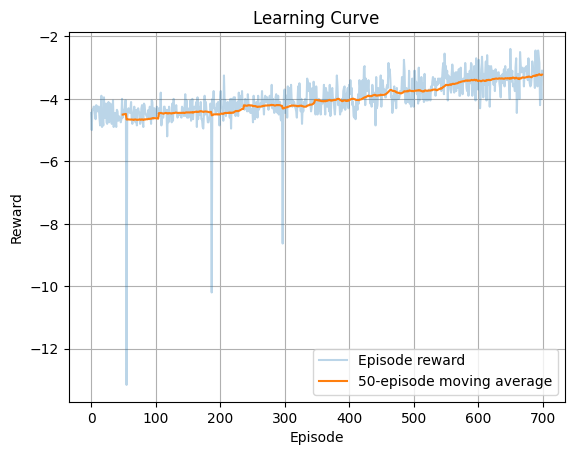

In [ ]:
def plot_learning_average(rewards, window=50):
    """
    Plot episode rewards and their moving average.

    Args:
        rewards (list or np.array): episode rewards
        window (int): moving average window size
    """
    rewards = np.array(rewards)

    if len(rewards) < window:
        print("Not enough episodes to compute moving average")
        return

    moving_avg = np.convolve(
        rewards,
        np.ones(window) / window,
        mode="valid"
    )

    plt.figure()
    plt.plot(rewards, alpha=0.3, label="Episode reward")
    plt.plot(
        range(window - 1, len(rewards)),
        moving_avg,
        label=f"{window}-episode moving average"
    )
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{CHECKPOINT_DIR}/learning_curve.png")
    plt.show()
plot_learning_average(episode_rewards, window=50)
